In [96]:
import pandas as pd
import pyarrow
from datetime import date
import matplotlib.pyplot as plt

In [207]:
wosis = pd.read_csv(
    "data/wosis_latest_orgc.csv",
    usecols=[
        "X", 
        "Y", 
        "profile_id", 
        "profile_layer_id", 
        "upper_depth", 
        "lower_depth", 
        "orgc_value_avg", 
        "orgc_date",
        "orgc_profile_code"
    ]
)

In [208]:
def process_datestring(d):
    """
    Returns a proper date from the WoSIS date dictionary string.
    """
    def _validate(d):
        # Should follow a standard pattern
        if '?' in d:
            return None
        elif d[0:3] != '{1:':
            return None
        else:
            return d

    if _validate(d) is not None:
        d = d.strip("}")
        first_date = d.split(',')[0]
        datestr = first_date[3:]
        date = datetime.strptime(datestr, '%Y-%m-%d').date()
        return date
    else:
        return None

In [213]:
wosis["date"] = wosis["orgc_date"].apply(process_datestring)

# major drop in data when cleaning up dates 469253 to 292892 observations
wosis_orig = wosis.dropna()

# another, bigger drop when limiting range to when Landsat 7 was available
# from 292892 to 68772, representing 15242 sites
l7start = datetime(1999, 1, 1).date()
wosis = wosis_orig[wosis_orig.date > l7start]
print(len(set(wosis.profile_id)))

wosis.to_pickle("data/cleaned_wosis.pkl")

15242
                 X          Y  profile_id  profile_layer_id  upper_depth  \
0         4.666901  50.649889       36897            152510          0.0   
1         4.666901  50.649889       36897            152512          3.0   
2         4.666901  50.649889       36897            152513          6.0   
3         4.666901  50.649889       36897            152514          9.0   
4         4.666901  50.649889       36897            152517         18.0   
...            ...        ...         ...               ...          ...   
469055  151.875381 -24.190285      623728           3178200         25.0   
469056  151.875381 -24.190285      623728           3178201         30.0   
469057  151.875381 -24.190285      623728           3178202         35.0   
469058  151.875381 -24.190285      623728           3178203         40.0   
469059  151.875381 -24.190285      623728           3178204         45.0   

        lower_depth  orgc_value_avg      orgc_date orgc_profile_code  \
0        

/Users/danhammer/Dropbox/github/earthrise-media/fire-viz/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


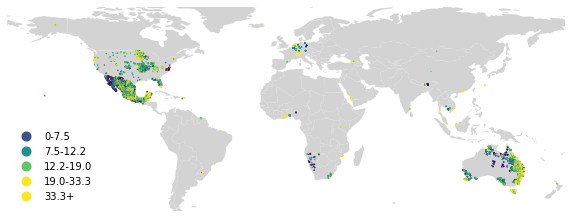

In [94]:
import geopandas 
import mapclassify as mc
import geoplot

df = wosis[["X", "Y", "orgc_value_avg"]]
df.columns = ["lng", "lat", "orgc_value_avg"]
grouped_df = df.groupby(['lng', 'lat']).mean()
grouped_df = grouped_df.reset_index()
ocarbon = grouped_df[["lng", "lat", "orgc_value_avg"]]
gdf = geopandas.GeoDataFrame(
    ocarbon, 
    geometry=geopandas.points_from_xy(ocarbon.lng, ocarbon.lat)
)

scheme = mc.Quantiles(wosis['orgc_value_avg'], k=5)

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = geoplot.polyplot(
    world,
    edgecolor='None',
    facecolor='lightgray',
    figsize=(10, 5)
)

geoplot.pointplot(
    gdf,
    hue='orgc_value_avg',
    scheme=scheme,
    ax=ax,
    s=0.5,
    legend=True,
    legend_var='hue',
    legend_values=[1, 2, 3, 4, 5],
    legend_labels=['0-7.5', '7.5-12.2', '12.2-19.0', '19.0-33.3', '33.3+'],
    legend_kwargs={'frameon': False}
)

# They basically all come from Mexico and Australia
plt.savefig("imgs/wosis_recent_points.png", dpi=150)

In [100]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

Enter verification code: 4/4QGXKIr-jR1eOHZ3yb-ZVmlzGphYwmcnRFohHs7hUcZ5_aS3Yf7UDYA

Successfully saved authorization token.


In [218]:
# Save for upload to Google Earth Engine
wosis_geo = wosis[["X", "Y", "profile_id", "date"]]
wosis_geo["year"] = wosis_geo["date"].apply(lambda x: x.year)
wosis_geo = wosis_geo.groupby(['profile_id']).mean()
wosis_geo = wosis_geo.reset_index()
sample_gdf = geopandas.GeoDataFrame(
    wosis_geo, 
    geometry=geopandas.points_from_xy(wosis_geo["X"], wosis_geo["Y"])
)
sample_gdf.to_file("data/wosis_sample.shp")

/Users/danhammer/Dropbox/github/earthrise-media/fire-viz/env/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


                 X          Y  profile_id        date  year
0         4.666901  50.649889       36897  2012-03-22  2012
1         4.666901  50.649889       36897  2012-03-22  2012
2         4.666901  50.649889       36897  2012-03-22  2012
3         4.666901  50.649889       36897  2012-03-22  2012
4         4.666901  50.649889       36897  2012-03-22  2012
...            ...        ...         ...         ...   ...
469055  151.875381 -24.190285      623728  2014-07-01  2014
469056  151.875381 -24.190285      623728  2014-07-01  2014
469057  151.875381 -24.190285      623728  2014-07-01  2014
469058  151.875381 -24.190285      623728  2014-07-01  2014
469059  151.875381 -24.190285      623728  2014-07-01  2014

[68772 rows x 5 columns]


In [220]:
rect = ee.Geometry.Rectangle(-92, 36, -88, 38)
wosis_gee = ee.FeatureCollection('users/danhammer/soilcarbon/wosis_sample')
filtered = wosis_gee.filterBounds(rect)
dataset = ee.ImageCollection('LANDSAT/LE7_TOA_1YEAR')

In [240]:
def addavg(pt, buffer=2000):
    f = ee.Feature(pt)
    yr = pt.get('year').getInfo()
    region = f.buffer(buffer)
    
    img = ee.Image('LANDSAT/LE7_TOA_1YEAR/%s' % yr)
    
    avg = img.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region.geometry(),
        scale=250
    )

    x = avg.getInfo()
    return pt.set({"band_list": x})

# addavg(filtered.first()).getInfo()
avgAdded = filtered.map(addavg).getInfo()

EEException: ValueNode is empty

In [182]:
avgAdded

{'type': 'FeatureCollection',
 'columns': {},
 'version': 1600717769564081,
 'id': 'users/danhammer/soilcarbon/wosis_sample',
 'properties': {'system:asset_size': 1003279},
 'features': []}

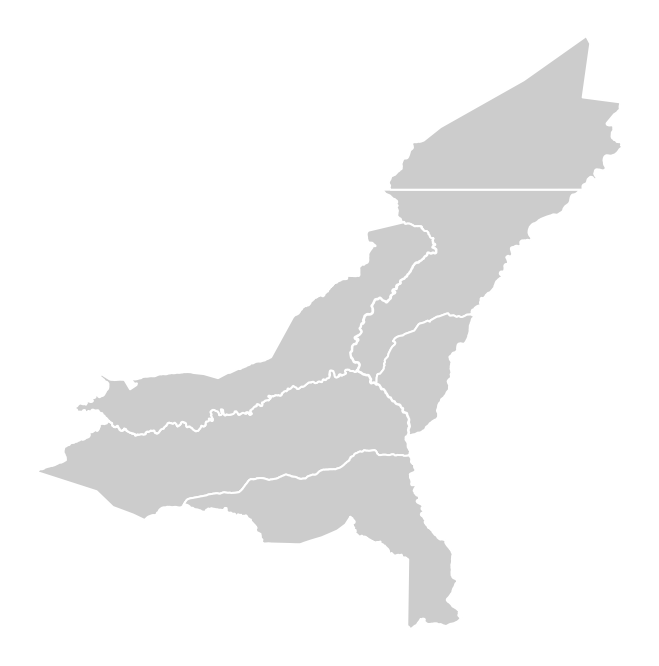

In [137]:
gdf = geopandas.read_file("data/GMA_Luangwa_Lower_Zambezi_region.shp")
f, ax = plt.subplots(figsize=(12, 12))
gdf.plot(ax=ax, facecolor="#cccccc", edgecolor='white', linewidth=2)
ax.axis('off')
plt.savefig('zmb.png', transparent=True)